In [1]:
import sys, os
a_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'python_generated'))
# insert it at front so imports find it first
sys.path.insert(0, a_path)
import message_pb2

/opt/homebrew/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.29.3 is exactly one major version older than the runtime version 6.31.0 at message.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


In [2]:
experiment = message_pb2.Experiment()
# Read the existing address book.
with open('../data/experiment-1747516336.pb', 'rb') as f:
  experiment.ParseFromString(f.read())

In [29]:
idx = 5
experiment.results[2].perturbations[0].trajectories[0].states[idx].state == experiment.results[2].perturbations[1].trajectories[0].states[idx].state

False

In [19]:
experiment.results[2].perturbations[1].trajectories[0].states[1].state

[True, False, True, False, False, False, True, True, True, False, False, False, False, False, False, True, True, True, False, True, True, False, False, False, True, False, True, False, False, False, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, True, False, False, True, False, True, True, False, False, False, False, True, False, False, False, False, True, False, True, True, True, False, True, True, False, False, False, True, True, False, True, True, False, False, True, False, False, False, True, False, False, True, True, False, False, False, False, False, True, True, False, True, False, False, False, True, True, True, True, True, False, False, True, False, True, False, False, True, False, True, True, False, True, True, False, False, False, True, True, False, False, False, True, False, True, False, False, True, False, False, True, True, True, False, True, True, True, False, False, False, True, T

In [35]:
import numpy as np
# (network, drug, initial_condition, time/step, node_idx)
A = np.array([
  np.array([
    np.array([
      np.array([
        np.array(state.state)
        for state in trajectory.states
      ])
      for trajectory in perturbation.trajectories
    ])
    for perturbation in result.perturbations
  ])
  for result in experiment.results
])

In [36]:
A.shape

(100, 51, 12, 51, 500)

In [39]:
import pandas as pd
hamming_distance_data = []

for network_idx in range(experiment.experiment_config.num_networks):
  for drug_idx in range(experiment.experiment_config.drug_config.num_drugs):
    for initial_condition_idx in range(experiment.experiment_config.dynamics_config.num_initial_conditions):
      hs = (A[network_idx,0,initial_condition_idx] ^ A[network_idx,drug_idx,initial_condition_idx]).mean(axis=1)
      for step_num, h in enumerate(hs):
        hamming_distance_data.append({
          'network_idx': network_idx,
          'drug_idx': drug_idx,
          'initial_condition_idx': initial_condition_idx,
          'step_num': step_num,
          'hamming_distance': h,
        })

hamming_distance_df = pd.DataFrame(hamming_distance_data)

<Axes: xlabel='step_num', ylabel='hamming_distance'>

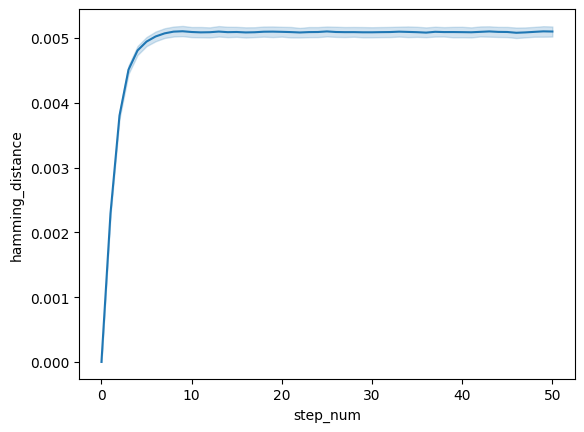

In [40]:
import seaborn as sns
sns.lineplot(
  data=hamming_distance_df,
  x='step_num',
  y='hamming_distance',
)

In [9]:
import networkx as nx
G, G_perturbed = nx.DiGraph(), nx.DiGraph()

In [10]:
for edge in experiment.results[0].perturbations[0].perturbed_network.edges:
  G.add_edge(edge.source, edge.target, weight=edge.weight)

for edge in experiment.results[0].perturbations[1].perturbed_network.edges:
  G_perturbed.add_edge(edge.source, edge.target, weight=edge.weight)

{(0, 0): 0.7639304214661791, (0, 2): -0.13450372088482565, (0, 4): -0.6114246672282402, (0, 5): 0.7845787979706134, (0, 8): -0.7157938231883896, (0, 9): -0.21896385052362222, (5, 0): -0.6800394518346926, (5, 1): -0.9468987420038557, (5, 2): -0.12300401990488075, (5, 3): 0.8424485662725569, (5, 5): -0.9043260377487599, (9, 0): -0.6007179480752338, (1, 3): -0.020656701157347968, (2, 6): -0.4703807535979472, (3, 2): 0.24967972140175876, (7, 2): -0.21703719485031758, (4, 5): 0.2652967460235587, (6, 9): -0.4707934671106888, (8, 6): -0.6178978372830417}


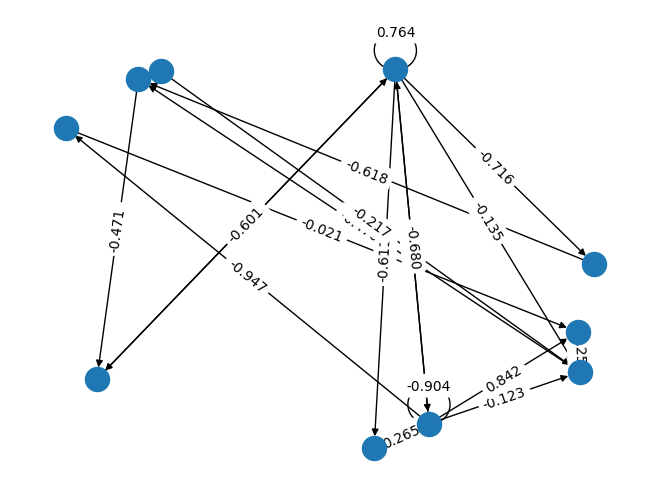

In [19]:
pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos=pos)
labels = nx.get_edge_attributes(G, 'weight')
print(labels)
_ = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={loc: f'{weight:.3f}' for loc, weight in labels.items()})

{(0, 0): 0.7639304214661791, (0, 2): -0.13450372088482565, (0, 4): -0.6114246672282402, (0, 5): 0.7845787979706134, (0, 8): -0.7157938231883896, (0, 9): -0.21896385052362222, (5, 0): -0.6800394518346926, (5, 1): -0.9468987420038557, (5, 2): -0.12300401990488075, (5, 3): 0.8424485662725569, (5, 5): -0.9043260377487599, (9, 0): -0.8507179480752338, (1, 3): -0.020656701157347968, (2, 6): -0.4703807535979472, (3, 2): 0.24967972140175876, (7, 2): -0.4670371948503176, (4, 5): 0.2652967460235587, (6, 9): -0.4707934671106888, (8, 6): -0.3678978372830417}


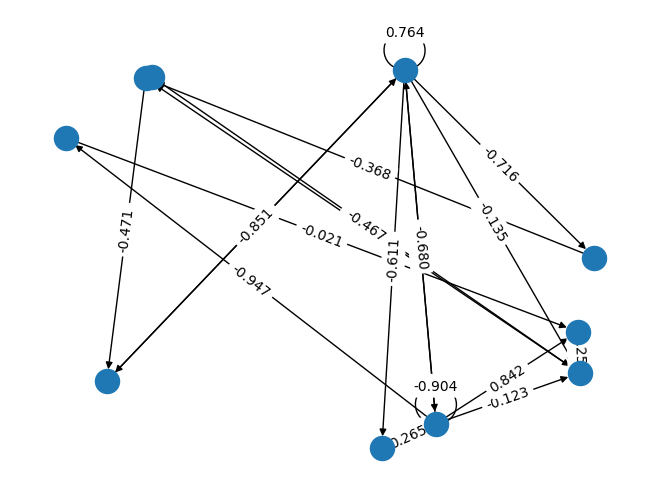

In [18]:
pos = nx.spring_layout(G_perturbed, seed=0)
nx.draw(G_perturbed, pos=pos)
labels = nx.get_edge_attributes(G_perturbed, 'weight')
print(labels)
_ = nx.draw_networkx_edge_labels(G_perturbed, pos=pos, edge_labels={loc: f'{weight:.3f}' for loc, weight in labels.items()})

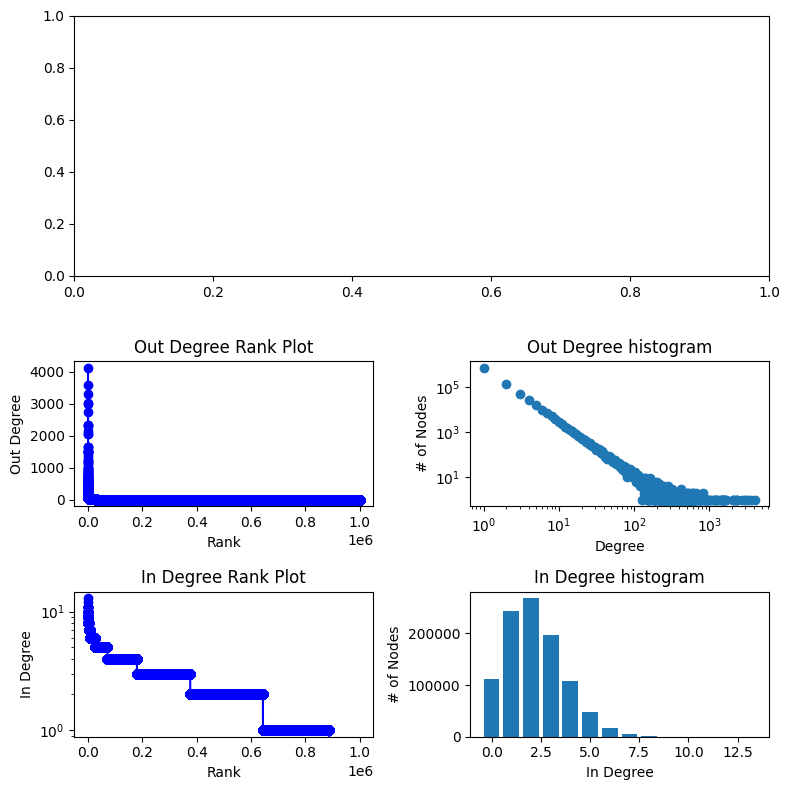

In [57]:
import matplotlib.pyplot as plt
import numpy as np
out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)
in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
d_out_max = max(out_degree_sequence)
d_in_max = max(in_degree_sequence)

fig = plt.figure("Degrees of power law graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(3+2+2, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
# Gcc = G.subgraph(sorted(nx.strongly_connected_components(G), key=len, reverse=True)[0])
# pos = nx.spring_layout(Gcc)
# nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
# nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
# ax0.set_title("Largest strongly Connected component of G")
# ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:5, :2])
ax1.plot(out_degree_sequence, "b-", marker="o")
ax1.set_title("Out Degree Rank Plot")
ax1.set_ylabel("Out Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:5, 2:])
ax2.scatter(*np.unique(out_degree_sequence, return_counts=True))
ax2.set_title("Out Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel("# of Nodes")

ax1 = fig.add_subplot(axgrid[5:7, :2])
ax1.plot(in_degree_sequence, "b-", marker="o")
ax1.set_yscale('log')
ax1.set_title("In Degree Rank Plot")
ax1.set_ylabel("In Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[5:7, 2:])
ax2.bar(*np.unique(in_degree_sequence, return_counts=True))
ax2.set_title("In Degree histogram")
ax2.set_xlabel("In Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [58]:
A = np.array([
  np.array([
    np.array(trajectories.results[trial_idx].states[step_idx].state)
    for step_idx in range(trajectories.dynamics_config.num_steps)
  ])
  for trial_idx in range(trajectories.dynamics_config.num_trials)
])

In [59]:
import pandas as pd
hamming_distance_data = []
for trial_idx_1 in range(trajectories.dynamics_config.num_trials):
  for trial_idx_2 in range(trial_idx_1+1, trajectories.dynamics_config.num_trials):
    hs = (A[trial_idx_1] ^ A[trial_idx_2]).mean(axis=1)
    for t, h in enumerate(hs):
      hamming_distance_data.append({
        'trial_idx_1': trial_idx_1,
        'trial_idx_2': trial_idx_2,
        'time': t,
        'hamming_distance': h,
      })

hamming_distance_df = pd.DataFrame(hamming_distance_data)

In [97]:
np.mean(out_degree_sequence)

np.float64(2.1942)

In [98]:
np.mean(in_degree_sequence)

np.float64(2.1942)

In [89]:
r_nodes = np.random.choice(range(int(1e6)), size=(10,))

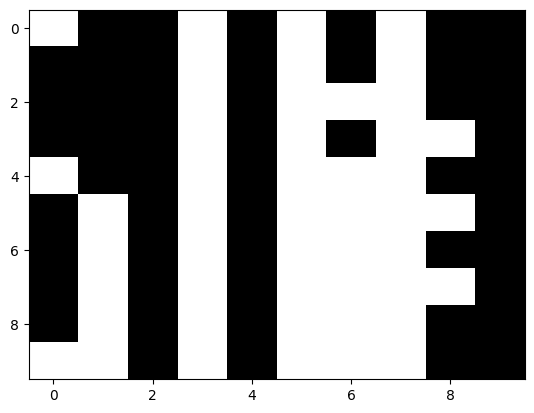

In [96]:
plt.imshow(A[:,6,r_nodes], aspect='auto', cmap='grey')